In [1]:
import torch
from torch import nn

import torch.functional as F
import torchvision.transforms.functional as TF
import torch.utils.checkpoint as checkpoint

from PIL import Image

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import numpy as np
import random

import requests
import io

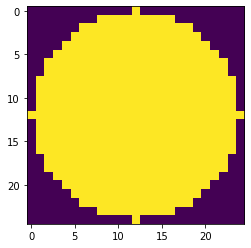

In [2]:
neighborhood = 25

center = neighborhood // 2

y, x = np.ogrid[-center : center + 1, -center : center + 1]
mask = torch.Tensor(x * x + y * y <= (neighborhood // 2) ** 2).bool()

neighborhood_kernel = torch.zeros(neighborhood, neighborhood).cuda()
neighborhood_kernel[mask] = 1

neighborhood_kernel = neighborhood_kernel[None, None, :]

plt.imshow(neighborhood_kernel[0, 0].cpu())

In [8]:
class Automata(nn.Module):
    def __init__(self, grid_size, n_channels):

        super(Automata, self).__init__()

        self.n_channels = n_channels
        self.grid_size = grid_size

        self.filters = torch.Tensor(
            [
                [[[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]],
                [[[-1, -2, -1], [0, 0, 0], [1, 2, 1]]],
                [[[0, 0, 0], [0, 1, 0], [0, 0, 0]]],
            ]
        ).cuda()

        self.mapper = nn.Sequential(
            nn.Linear(3 * n_channels, 128),
            nn.ReLU(),
            nn.Linear(128, n_channels),
            nn.Tanh(),
        )

        self.mapper[2].weight.data.fill_(0)
        self.mapper[2].bias.data.fill_(0)

    def perception(self, x):

        # reshape for same convolution across channels
        x = x.reshape(-1, 1, self.grid_size[0], self.grid_size[1])

        # toroidal padding
        conved = nn.functional.pad(x, (1, 1, 1, 1), mode="circular")

        conved = nn.functional.conv2d(conved, model.filters)

        # reshape for perception computations
        conved = conved.view(self.batch_size, 3 * self.n_channels, -1)
        conved = conved.transpose(1, 2)

        conved = self.mapper(conved)

        conved = conved.transpose(1, 2)
        # (batch_size, channels, total_cells)

        conved = conved.view(self.batch_size, self.n_channels, *self.grid_size)

        can_update = torch.rand_like(conved) < 0.5

        return conved * can_update

    def forward(self, x, iterations, keep_history=False):

        if keep_history:

            model.history = torch.zeros(iterations, *x.shape)

        model.batch_size = x.shape[0]

        x.requires_grad = True

        prev = torch.zeros_like(x)

        for i in range(iterations):

            next_alive = (
                nn.functional.max_pool2d(x[:, 3], (3, 3), stride=1, padding=1) > 1 / 8
            )

            next_alive = next_alive.unsqueeze(1)

            alive_indicators = nn.functional.pad(
                x[:, 3][:, None], [neighborhood // 2] * 4, mode="circular"
            )
            neighbor_density = nn.functional.conv2d(
                alive_indicators, neighborhood_kernel
            )
            neighbor_density = neighbor_density[:, 0]

            too_dense = neighbor_density.unsqueeze(1) < float(
                neighborhood_kernel.sum() * 0.25
            )

            is_alive = next_alive * too_dense

            x = x + checkpoint.checkpoint(self.perception, x)

            x = x * is_alive

            x[:, :4].clamp_(0, 1)

            if keep_history:

                model.history[i] = x.detach()

            if i == iterations - 2:
                prev = x.clone()

        return x, prev

In [ ]:
n_channels = 16
n_epochs = 250
lr = 0.001
batch_size = 8

model = Automata((128, 128), n_channels).cuda()

losses = []

# initialize pool with seeds
seed = torch.zeros(n_channels, 128, 128).cuda()
seed[3:, 64, 64] = 1

criterion = nn.MSELoss(reduction="none")
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for i in range(n_epochs):

    iterations = random.randint(125, 150)

    initial_states = seed[None, :].repeat(batch_size, 1, 1, 1)

    out, prev = model(initial_states, iterations, keep_history=True)

    optimizer.zero_grad()

    alives = out[:, 3]
    prev_alives = prev[:, 3]

    vitality_loss = -alives.mean() * 0.1
    stability_loss = ((alives - prev_alives) ** 2).mean()

    loss = vitality_loss + stability_loss

    loss.backward()
    optimizer.step()

    if i % 10 == 0:

        print(i, float(loss.cpu().detach()))

    losses.append(float(loss))

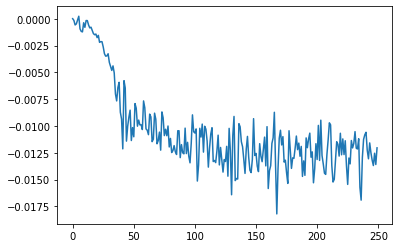

In [10]:
plt.plot(losses)

In [11]:
with torch.no_grad():
    out = model(seed[None, :], 512, keep_history=True)
    video = model.history.cpu().detach()
    video = video[:, 0, :4]
    video = video.transpose(1, 3)

/home/khu/anaconda3/envs/cenv/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


In [12]:
from matplotlib import animation
from IPython.display import HTML

fig = plt.figure()
im = plt.imshow(video[0, :, :, 3])

plt.close()


def init():
    im.set_data(video[0, :, :, 3])


def animate(i):
    im.set_data(video[i, :, :, 3])
    return im


anim = animation.FuncAnimation(
    fig, animate, init_func=init, frames=video.shape[0], interval=50
)
HTML(anim.to_html5_video())